Tic Tac Toe
---
Two players against each other

<img style="float:left" src="board.png" alt="drawing" width="200"/>

In [30]:
import numpy as np
import pickle
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
BOARD_ROWS = 3
BOARD_COLS = 3

### Board State
---
Reflect & Judge the state

2 players p1 and p2; p1 uses symbol 1 and p2 uses symbol 2, vacancy as 0

In [16]:
class State:
    def __init__(self, p1, p2):
        self.board = np.zeros((BOARD_ROWS, BOARD_COLS))
        self.p1 = p1
        self.p2 = p2
        self.isEnd = False
        self.boardHash = None
        # init p1 plays first
        self.playerSymbol = 1
        self.results = []
        
        # Kinori added
        self.p1_wins = 0
        self.p2_wins = 0
        self.tie = 0
        self.games = 0
        
    def reset_metrics(self):
        self.p1_wins = 0
        self.p2_wins = 0
        self.tie = 0
        self.games = 0
        
    # get unique hash of current board state
    def getHash(self):
#         print('state', self.board)
        board_str = ''
        for pos in self.board.reshape(BOARD_COLS*BOARD_ROWS):
            if pos == -1:
                board_str += '2'
            else:
                board_str += str(int(pos))
        self.boardHash = board_str
#         self.boardHash = str(self.board.reshape(BOARD_COLS*BOARD_ROWS))
        return self.boardHash
    
    def winner(self):
        # row
        for i in range(BOARD_ROWS):
            if sum(self.board[i, :]) == 3:
                self.isEnd = True
                return 1
            if sum(self.board[i, :]) == -3:
                self.isEnd = True
                return -1
        # col
        for i in range(BOARD_COLS):
            if sum(self.board[:, i]) == 3:
                self.isEnd = True
                return 1
            if sum(self.board[:, i]) == -3:
                self.isEnd = True
                return -1
        # diagonal
        diag_sum1 = sum([self.board[i, i] for i in range(BOARD_COLS)])
        diag_sum2 = sum([self.board[i, BOARD_COLS-i-1] for i in range(BOARD_COLS)])
        diag_sum = max(diag_sum1, diag_sum2)
        if diag_sum == 3:
            self.isEnd = True
            return 1
        if diag_sum == -3:
            self.isEnd = True
            return -1
        
        # tie
        # no available positions
        if len(self.availablePositions()) == 0:
            self.isEnd = True
            return 0
        # not end
        self.isEnd = False
        return None
    
    def availablePositions(self):
        positions = []
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                if self.board[i, j] == 0:
                    positions.append((i, j))  # need to be tuple
        return positions
    
    def updateState(self, position):
        self.board[position] = self.playerSymbol
        # switch to another player
        self.playerSymbol = -1 if self.playerSymbol == 1 else 1
    
    # only when game ends
    def giveReward(self):
        result = self.winner()
        # backpropagate reward
        self.games += 1 # Kinori added
        if result == 1:
            self.p1_wins += 1 # Kinori added
            self.p1.feedReward(1)
            self.p2.feedReward(0)
        elif result == -1:
            self.p2_wins += 1 # Kinori added
            self.p1.feedReward(0)
            self.p2.feedReward(1)
        else:
            self.tie += 1 # Kinori added
            self.p1.feedReward(0.1)
            self.p2.feedReward(0.5)
    
    # board reset
    def reset(self):
        self.board = np.zeros((BOARD_ROWS, BOARD_COLS))
        self.boardHash = None
        self.isEnd = False
        self.playerSymbol = 1
    
    def play(self, rounds=100):
        for i in range(rounds):
#             if i%1000 == 0:
#                 print("Rounds {}".format(i))
            while not self.isEnd:
                # Player 1
                positions = self.availablePositions()
                p1_action = self.p1.chooseAction(positions, self.board, self.playerSymbol)
                # take action and upate board state
                self.updateState(p1_action)
                board_hash = self.getHash()
                self.p1.addState(board_hash)
                # check board status if it is end

                win = self.winner()
                if win is not None:
                    # self.showBoard()
                    # ended with p1 either win or draw
#                     self.results.append(win)           TODO RE-ADD BACK IN IF WANT TO USE
                    self.giveReward()
                    self.p1.reset()
                    self.p2.reset()
                    self.reset()
                    break

                else:
                    # Player 2
                    positions = self.availablePositions()
                    p2_action = self.p2.chooseAction(positions, self.board, self.playerSymbol)
                    self.updateState(p2_action)
                    board_hash = self.getHash()
                    self.p2.addState(board_hash)
                    
                    win = self.winner()
                    if win is not None:
                        # self.showBoard()
                        # ended with p2 either win or draw
#                         self.results.append(win)       TODO RE-ADD BACK IN IF WANT TO USE
                        self.giveReward()
                        self.p1.reset()
                        self.p2.reset()
                        self.reset()
                        break
    
    # play with human
    def play2(self):
        while not self.isEnd:
            # Player 1
            positions = self.availablePositions()
            p1_action = self.p1.chooseAction(positions, self.board, self.playerSymbol)
            # take action and upate board state
            self.updateState(p1_action)
            self.showBoard()
            # check board status if it is end
            win = self.winner()
            if win is not None:
                if win == 1:
                    print(self.p1.name, "wins!")
                else:
                    print("tie!")
                self.reset()
                break

            else:
                # Player 2
                positions = self.availablePositions()
                p2_action = self.p2.chooseAction(positions)

                self.updateState(p2_action)
                self.showBoard()
                win = self.winner()
                if win is not None:
                    if win == -1:
                        print(self.p2.name, "wins!")
                    else:
                        print("tie!")
                    self.reset()
                    break

    def showBoard(self):
        # p1: x  p2: o
        for i in range(0, BOARD_ROWS):
            print('-------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('-------------')    

In [4]:
class Player:
    def __init__(self, name, exp_rate=0.3, player_symbol=1, update_method='sarsa'):
        self.name = name
        self.states = []  # record all positions taken
        self.lr = 0.2
        self.exp_rate = exp_rate
        self.decay_gamma = 0.9
        self.states_value = {}  # state -> value
        self.player_symbol = player_symbol
        self.update_method = update_method
    
#     def getHash(self, board):
#         boardHash = str(board.reshape(BOARD_COLS*BOARD_ROWS))
#         return boardHash
    
        # get unique hash of current board state
    def getHash(self, board):
#         print('self', board)
        board_str = ''
        for pos in board.reshape(BOARD_COLS*BOARD_ROWS):
            if pos == -1:
                board_str += '2'
            else:
                board_str += str(int(pos))
        self.boardHash = board_str
#         self.boardHash = str(self.board.reshape(BOARD_COLS*BOARD_ROWS))
#         print(self.boardHash)
        return self.boardHash
    
    def chooseAction(self, positions, current_board, symbol):
        if np.random.uniform(0, 1) <= self.exp_rate:
            # take random action
            idx = np.random.choice(len(positions))
            action = positions[idx]
        else:
            value_max = -999
            for p in positions:
                next_board = current_board.copy()
                next_board[p] = symbol
                next_boardHash = self.getHash(next_board)
                value = 0 if self.states_value.get(next_boardHash) is None else self.states_value.get(next_boardHash)
                # print("value", value)
                if value >= value_max:
                    value_max = value
                    action = p
        # print("{} takes action {}".format(self.name, action))
        return action
    
    # append a hash state
    def addState(self, state):
        self.states.append(state)
        
    # Find the distance between states
    def is_next_state(self, old_state, new_state):
#         print('Compare', old_state, new_state)
        diff = []
        for pos1, pos2 in zip(old_state, new_state):
            if pos1 == pos2:
                continue
            if pos1 == '0' and pos2 != '0':
                diff.append(pos2)
            else:
                return False
#         print('diff', diff)
        return sorted(diff) == ['1','2']
    
    # at the end of game, backpropagate and update states value
    def feedReward(self, reward):
        if self.update_method == 'sarsa':
            for st in reversed(self.states):
                if self.states_value.get(st) is None:
                    self.states_value[st] = 0
                self.states_value[st] += self.lr*(self.decay_gamma*reward - self.states_value[st])
                reward = self.states_value[st]
                
        if self.update_method == 'expected_sarsa':
#             print('ss', self.states, 'reward', reward)
            for st in reversed(self.states):
                if self.states_value.get(st) is None:
                    self.states_value[st] = 0
                possible_states = []
                if reward is None:
                    for next_st in self.states_value:
                        if self.is_next_state(st, next_st):
                            possible_states.append((next_st, self.states_value[next_st]))
                    reward = max([_[1] for _ in possible_states])
#                     print(possible_states, reward)
                self.states_value[st] += self.lr*(self.decay_gamma*reward - self.states_value[st])
#                 print(self.states_value)
                reward = None
                
#             reward = self.states_value[st]
            
        # at the end of game, backpropagate and update states value
#     def feedReward(self, reward):
# #         print("Feeding reward", self.player_symbol)
# #         print(self.states)
#         for st in reversed(self.states):
# #             print(st)
#             if self.states_value.get(st) is None:
#                 self.states_value[st] = 0
#             possible_states = []
#             if reward is None:
#                 for next_st in self.states_value:
#                     if self.find_dist(st, next_st) == 1:
#                         possible_states.append(next_st, self.states_value[st])
#                 reward = max([_[1] for _ in possible_states])
#                 reward = None
# #             print(reward)
#             self.states_value[st] += self.lr*(self.decay_gamma*reward - self.states_value[st])
# #             reward = self.states_value[st]
# #         print(possible_states, reward)
# #         print(self.states_value)
            
    def reset(self):
        self.states = []
        
    def savePolicy(self):
        fw = open('policy_' + str(self.name), 'wb')
        pickle.dump(self.states_value, fw)
        fw.close()

    def loadPolicy(self, file):
        fr = open(file,'rb')
        self.states_value = pickle.load(fr)
        fr.close()

In [6]:
p1 = Player("p1", update_method='expected_sarsa')
p2 = RandomPlayer("p2")
st = State(p1, p2)
st.play(1)

NameError: ignored

In [17]:
p1 = Player("p1", update_method='sarsa')
# p1 = Player("p1")
p2 = Player("p2", update_method='sarsa')
# p1 = RandomPlayer("p1")
# p2 = RandomPlayer("p2")

st = State(p1, p2)
# print("training...")
# st.play(1000)

for i in range(10):
    # Train
    st.results = []
    p1.exp_rate = 0.3
    p2.exp_rate = 0.3
    st.play(2000)
    print('Train', Counter(st.results)[1] / 2000 * 100, '%, Tie', Counter(st.results)[0] / 2000 * 100, '%')
    
    # Eval
    st.results = []
    p1.exp_rate = 0
    p2.exp_rate = 0
    st.play(200)
#     print(Counter(st.results))
#     print(Counter(st.results)[1])
#     Counter(st.results)[0]
    print('Eval P1 win', Counter(st.results)[1] / 200 * 100, '%, Tie', Counter(st.results)[0] / 200 * 100, '%')
    print(Counter(st.results))
    
    

Train 0.0 %, Tie 0.0 %


KeyboardInterrupt: 

In [5]:
class HumanPlayer:
    def __init__(self, name):
        self.name = name 
    
    def chooseAction(self, positions):
        while True:
            row = int(input("Input your action row:"))
            col = int(input("Input your action col:"))
            action = (row, col)
            if action in positions:
                return action
    
    # append a hash state
    def addState(self, state):
        pass
    
    # at the end of game, backpropagate and update states value
    def feedReward(self, reward):
        pass
            
    def reset(self):
        pass

In [9]:
class RandomPlayer:
    def __init__(self, name):
        self.name = name
        self.update_method = "Random Player"
    
    def chooseAction(self,  positions, current_board, symbol):
#         print(positions)
        return positions[np.random.choice(len(positions))]
    
    # append a hash state
    def addState(self, state):
        pass
    
    # at the end of game, backpropagate and update states value
    def feedReward(self, reward):
        pass
            
    def reset(self):
        pass

P1 method: 'sarsa', P2 method 'sarsa'
Epochs: 150, Total Training Games: 15000, Games per Epoch: 100
Eval Games per iteration: 1000


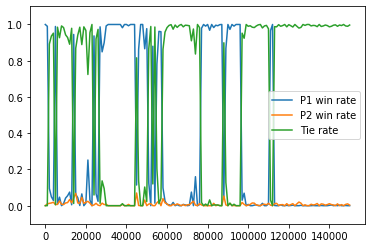

P1 method: 'sarsa', P2 method 'expected_sarsa'
Epochs: 150, Total Training Games: 15000, Games per Epoch: 100
Eval Games per iteration: 1000


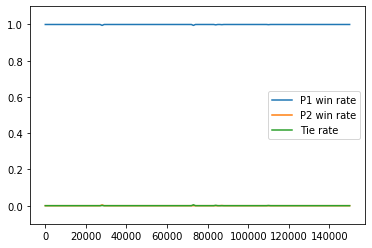

P1 method: 'sarsa', P2 method 'Random Player'
Epochs: 150, Total Training Games: 15000, Games per Epoch: 100
Eval Games per iteration: 1000


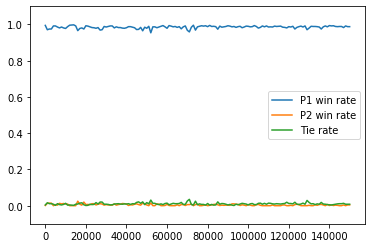

P1 method: 'expected_sarsa', P2 method 'sarsa'
Epochs: 150, Total Training Games: 15000, Games per Epoch: 100
Eval Games per iteration: 1000


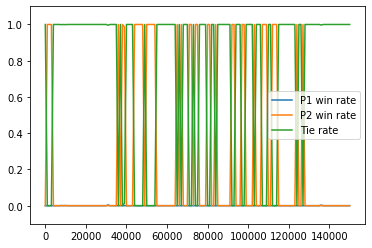

In [ ]:
iterations = 150
train_games_per_iteration = 100
eval_games_per_iteration = 1000
verbose = False
visualize = True
start_from_0 = True

P1 = [Player("p1", update_method='sarsa'), Player("p1", update_method='expected_sarsa'), RandomPlayer("p1")]
P2 = [Player("p2", update_method='sarsa'), Player("p2", update_method='expected_sarsa'), RandomPlayer("p2")]
# p1 = P1[0]
# p2 = P2[0]

for p1 in P1:
    for p2 in P2:
        st = State(p1, p2)
        p1_win_rate = []
        p2_win_rate = []
        tie_rate = []
        if start_from_0:
            p1.exp_rate = 0
            p2.exp_rate = 0
            st.reset_metrics()
            st.play(eval_games_per_iteration)
            p1_win_rate.append(st.p1_wins/st.games)
            p2_win_rate.append(st.p2_wins/st.games)
            tie_rate.append(st.tie/st.games)
            
        for i in range(iterations):
            # Train
            p1.exp_rate = 0.3
            p2.exp_rate = 0.3
            st.reset_metrics()
            st.play(train_games_per_iteration)

            # Eval
            p1.exp_rate = 0
            p2.exp_rate = 0
            st.reset_metrics()
            st.play(eval_games_per_iteration)
            p1_win_rate.append(st.p1_wins/st.games)
            p2_win_rate.append(st.p2_wins/st.games)
            tie_rate.append(st.tie/st.games)
            if verbose:
                print("________________________________")
                print("P1 method: '{}', P2 method '{}'".format(p1.update_method, p2.update_method))
                print("Training Iteration: {}, Train Games: {}, Eval Games: {}".format(i+1, (i+1)*train_games_per_iteration, eval_games_per_iteration))
                print("\tP1 win\tP2 win\tTie")
                print('Win\t{}\t{}\t{}'.format(p1_win_rate[-1], p2_win_rate[-1], tie_rate[-1]))
        if visualize:
            if start_from_0:
                games = np.arange(0, (iterations+1)*eval_games_per_iteration, eval_games_per_iteration)
            else:
                games = np.arange(eval_games_per_iteration, (iterations+1)*eval_games_per_iteration, eval_games_per_iteration)
            print("P1 method: '{}', P2 method '{}'".format(p1.update_method, p2.update_method))
            print("Epochs: {}, Total Training Games: {}, Games per Epoch: {}".format(iterations, iterations*train_games_per_iteration, train_games_per_iteration))
            print("Eval Games per iteration: {}".format(eval_games_per_iteration))
#             axes, fig = 
            p1_plot = plt.plot(games, p1_win_rate, label="P1 win rate")
            p2_plot = plt.plot(games, p2_win_rate, label="P2 win rate")
            tie_plot = plt.plot(games, tie_rate, label="Tie rate")
            plt.ylim(-0.1,1.1)
            plt.legend()
            plt.show()


### Training

In [ ]:
p1 = Player("p1", player_symbol=1)
p2 = Player("p2", player_symbol=-1)

st = State(p1, p2)
print("training...")
st.play(1000)

training...


KeyboardInterrupt: 

In [ ]:
# sorted(p1.states_value.items(), key=lambda x:x[1], reverse=True)

### Train and Eval

In [ ]:
p1 = Player("p1", update_method='expected_sarsa')
# p2 = Player("p2")
# p1 = RandomPlayer("p1")
p2 = RandomPlayer("p2")

st = State(p1, p2)
# print("training...")
# st.play(1000)

for i in range(10):
    # Train
    st.results = []
    p1.exp_rate = 0.3
    p2.exp_rate = 0.3
    st.play(200)
    print('Train', Counter(st.results))
    
    # Eval
    st.results = []
    p1.exp_rate = 0
    p2.exp_rate = 0
    st.play(200)
#     print(Counter(st.results))
#     print(Counter(st.results)[1])
#     Counter(st.results)[0]
    print('Eval P1 win', Counter(st.results)[1] / 200 * 100, '%, Tie', Counter(st.results)[0] / 200 * 100, '%')
    
    
    

ValueError: max() arg is an empty sequence

In [ ]:
p1.savePolicy()
p2.savePolicy()

AttributeError: 'RandomPlayer' object has no attribute 'savePolicy'

In [ ]:
p1.loadPolicy("policy_p1")

### Human vs Computer

In [ ]:
p1 = Player("computer", exp_rate=0)
p1.loadPolicy("policy_p1")

p2 = HumanPlayer("human")

st = State(p1, p2)
st.play2()

-------------
|   | x |   | 
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
Input your action row:2
Input your action col:1
-------------
|   | x |   | 
-------------
|   |   |   | 
-------------
|   | o |   | 
-------------
-------------
|   | x |   | 
-------------
|   |   |   | 
-------------
| x | o |   | 
-------------
Input your action row:3
Input your action col:1
Input your action row:2
Input your action col:2
-------------
|   | x |   | 
-------------
|   |   |   | 
-------------
| x | o | o | 
-------------
-------------
|   | x | x | 
-------------
|   |   |   | 
-------------
| x | o | o | 
-------------
Input your action row:1
Input your action col:1
-------------
|   | x | x | 
-------------
|   | o |   | 
-------------
| x | o | o | 
-------------
-------------
| x | x | x | 
-------------
|   | o |   | 
-------------
| x | o | o | 
-------------
computer wins!


In [ ]:
p1 = Player("computer", exp_rate=0)
p1.loadPolicy("policy_p1")

p2 = HumanPlayer("human")

st = State(p1, p2)
st.play2()

-------------
|   | x |   | 
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------


KeyboardInterrupt: Interrupted by user